In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os, gc

import warnings; warnings.filterwarnings('ignore')

## Reading user data

#### Here, we'll be using the OS library to go through the directory, then we'll be making a set of user IDS
#### After this, we find the intersection of the two sets (one from tappy and one from user data) to tell us for which patient IDs, tappy keystroke data is available

In [ ]:
user_file_list = os.listdir('../input/Archived-users/Archived users/')
user_set_v1 = set(map(lambda x: x[5: 15], user_file_list)) #[5: 15] to return just the user IDs


tappy_file_list = os.listdir('../input/Archived-Data/Tappy Data/')
user_set_v2 = set(map(lambda x: x[: 10], tappy_file_list)) #[: 10] to return just the user IDs


user_set = user_set_v1.intersection(user_set_v2)

len(user_set)

217

#### Function: `read_user_file`

##### Description:
This function reads a user file specified by the `file_name` parameter. It opens the file located in the '../input/Archived-users/Archived users/' directory, reads each line, extracts the data after the colon (':'), removes the trailing newline character, and returns the extracted data as a list.

##### Parameters:
- `file_name` (str): The name of the user file to be read.

##### Returns:
- `data` (list): A list containing the extracted data from the user file.

In [ ]:
def read_user_file(file_name):
    f = open('../input/Archived-users/Archived users/' + file_name)
    data = [line.split(': ')[1][: -1] for line in f.readlines()]
    f.close()

    return data

In [ ]:
files = os.listdir('../input/Archived-users/Archived users/') #Listing files in the specified directory

columns = [
    'BirthYear', 'Gender', 'Parkinsons', 'Tremors', 'DiagnosisYear',
    'Sided', 'UPDRS', 'Impact', 'Levadopa', 'DA', 'MAOB', 'Other'
] # efining column names for the DataFrame

user_df = pd.DataFrame(columns=columns) #creating an empty DataFrame with the specified columns

for user_id in user_set:
    temp_file_name = 'User_' + user_id + '.txt' #generating the file name based on user ID
    if temp_file_name in files: #checking if the file exists in the directory
        temp_data = read_user_file(temp_file_name) #reading data from the file using a custom function
        user_df.loc[user_id] = temp_data #adding data to the DataFrame using the user ID as index

user_df.head()


,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other
JHBOKKHOQW,1939,Female,True,True,2016,None,Don't know,Mild,True,False,False,False
AXXXXBBCCH,1949,Female,False,False,------,None,Don't know,------,False,False,False,False
ZCPALNB4ZM,1937,Female,True,True,2015,Right,Don't know,Severe,True,False,False,True
ZQ4UHHUPNZ,,Male,True,True,2013,None,Don't know,Medium,False,False,False,False
L7Q16SJ7KP,1965,Male,True,True,2007,Right,Don't know,Severe,True,False,True,False


In [ ]:
#force some columns to have numeric data type
user_df['BirthYear'] = pd.to_numeric(user_df['BirthYear'], errors='coerce')
user_df['DiagnosisYear'] = pd.to_numeric(user_df['DiagnosisYear'], errors='coerce')

In [ ]:
user_df = user_df.rename(index=str, columns={'Gender': 'Female'}) #renaming `Gender` to `Female`
user_df['Female'] = user_df['Female'] == 'Female' #change string data to boolean data
user_df['Female'] = user_df['Female'].astype(int) #change boolean data to binary data

In [ ]:
str_to_bin_columns = ['Parkinsons', 'Tremors', 'Levadopa', 'DA', 'MAOB', 'Other'] #columns to be converted to binary data

for column in str_to_bin_columns:
    user_df[column] = user_df[column] == 'True'
    user_df[column] = user_df[column].astype(int)

#### ONe hot encoding
We specify the columns that need to be one-hot encoded (`to_dummy_column_indices`).

For each column in the list, we perform the following steps:
1. Select columns before the target column using `user_df.iloc[:, : user_df.columns.get_loc(column)]`.
2. Perform one-hot encoding on the target column using `pd.get_dummies(user_df[column], prefix=str(column))`.
3. Select columns after the target column using `user_df.iloc[:, user_df.columns.get_loc(column) + 1 :]`.
4. Concatenate the three DataFrames (columns before, one-hot encoded column, and columns after) along the columns axis using `pd.concat`.

The resulting DataFrame (`user_df`) contains one-hot encoded columns for the specified categorical variables.


In [ ]:
#prior processing for `Impact` column
user_df.loc[
    (user_df['Impact'] != 'Medium') &
    (user_df['Impact'] != 'Mild') &
    (user_df['Impact'] != 'Severe'), 'Impact'] = 'None'

to_dummy_column_indices = ['Sided', 'UPDRS', 'Impact'] #columns to be one-hot encoded
for column in to_dummy_column_indices:
    user_df = pd.concat([
        user_df.iloc[:, : user_df.columns.get_loc(column)],
        pd.get_dummies(user_df[column], prefix=str(column)),
        user_df.iloc[:, user_df.columns.get_loc(column) + 1 :]
    ], axis=1)

user_df.head()

,BirthYear,Female,Parkinsons,Tremors,DiagnosisYear,Sided_Left,Sided_None,Sided_Right,UPDRS_1,UPDRS_2,...,UPDRS_4,UPDRS_Don't know,Impact_Medium,Impact_Mild,Impact_None,Impact_Severe,Levadopa,DA,MAOB,Other
JHBOKKHOQW,1939.0,1,1,1,2016.0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0
AXXXXBBCCH,1949.0,1,0,0,NaN,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
ZCPALNB4ZM,1937.0,1,1,1,2015.0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,1
ZQ4UHHUPNZ,NaN,0,1,1,2013.0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
L7Q16SJ7KP,1965.0,0,1,1,2007.0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,1,0


### Initial Visualizations

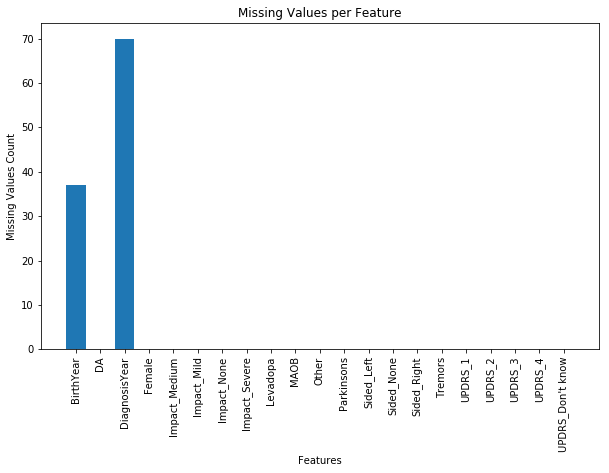

In [ ]:
missing = user_df.isnull().sum()
plt.figure(figsize=(10, 6))
plt.bar(missing.index, missing.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Missing Values Count')
plt.title('Missing Values per Feature')
plt.show()

In [ ]:
categorical_columns = ['Parkinsons', 'Tremors', 'Levadopa', 'DA', 'MAOB']

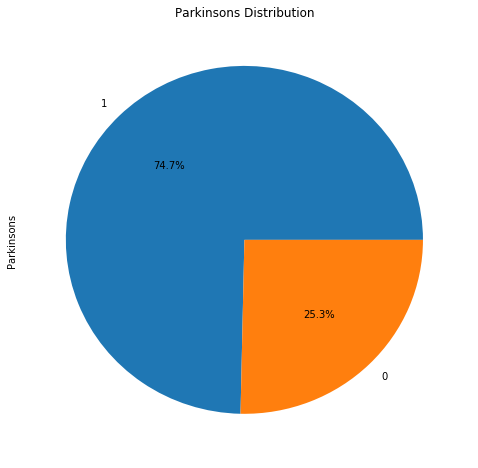

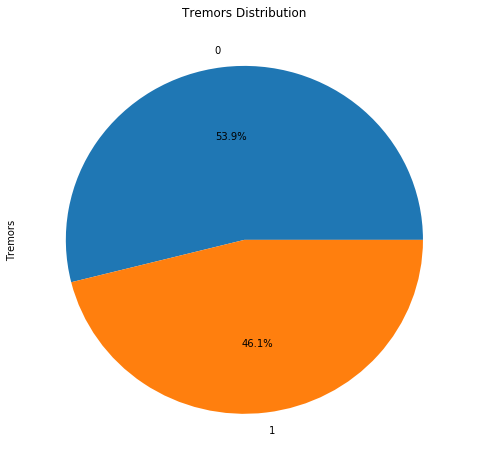

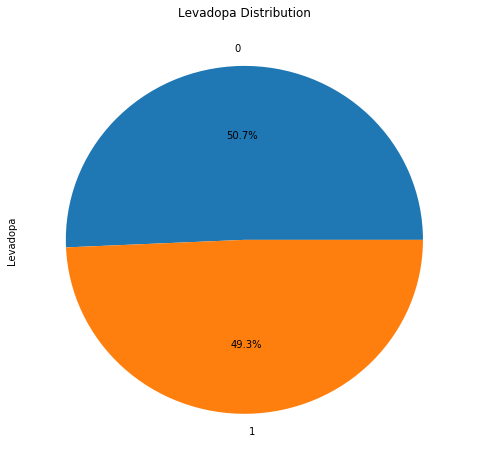

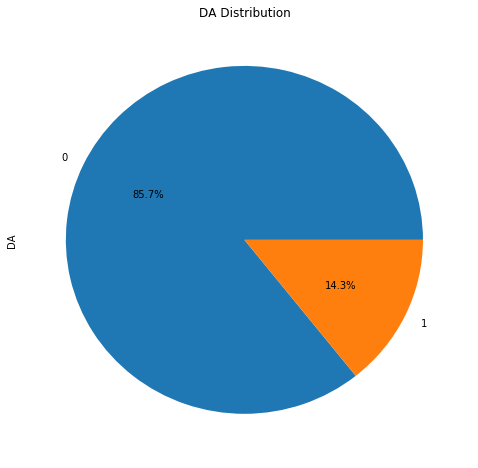

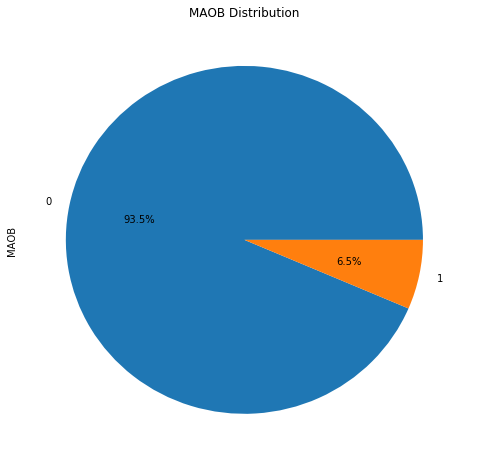

In [ ]:
for column in categorical_columns:
    plt.figure(figsize=(8, 8))
    user_df[column].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'{column} Distribution')
    plt.show()

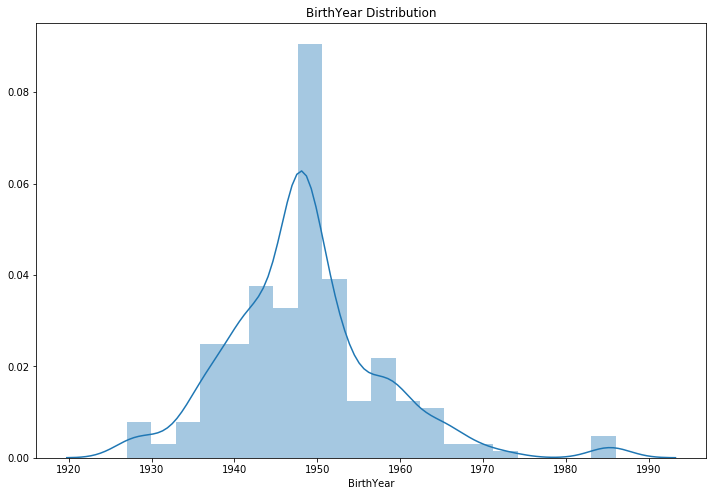

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(user_df['BirthYear'].fillna(user_df['BirthYear'].median()), kde=True)
plt.title('BirthYear Distribution')
plt.show()


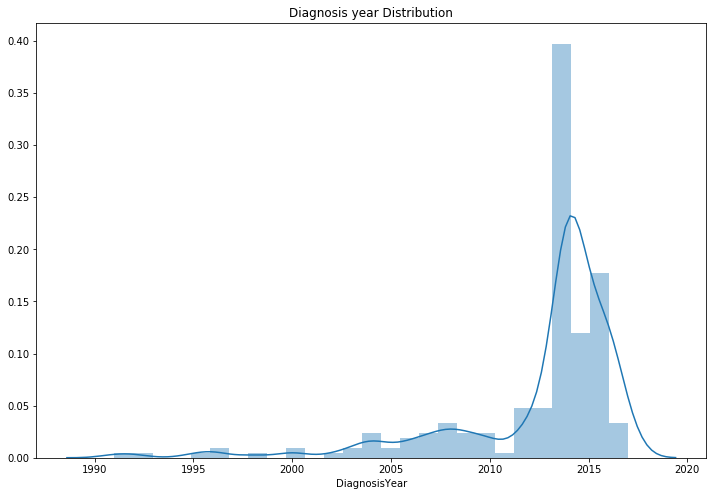

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(user_df['DiagnosisYear'].fillna(user_df['DiagnosisYear'].median()), kde=True)
plt.title('Diagnosis year Distribution')
plt.show()


- Count for different types in `Sided`, `UPDRS`, and `Impact`:

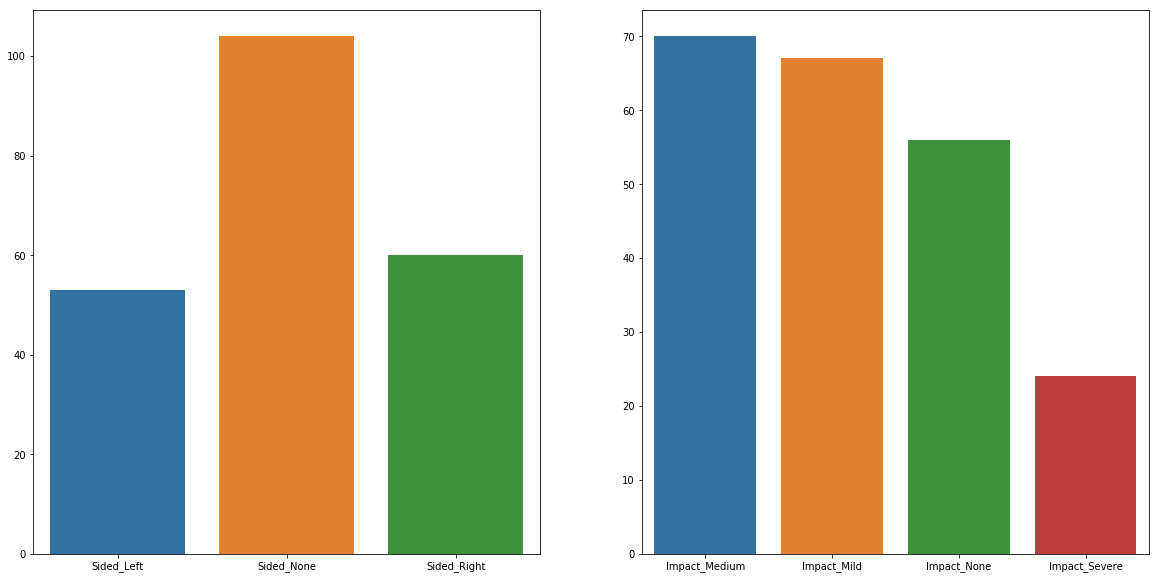

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.barplot(
    x=['Sided_Left', 'Sided_None', 'Sided_Right'],
    y=user_df[['Sided_Left', 'Sided_None', 'Sided_Right']].sum(),
    ax=ax[0]
)
sns.barplot(
    x=['Impact_Medium', 'Impact_Mild', 'Impact_None', 'Impact_Severe'],
    y=user_df[['Impact_Medium', 'Impact_Mild', 'Impact_None', 'Impact_Severe']].sum(),
    ax=ax[1]
)
plt.show()

## Reading in Typing Data

In [ ]:
file_name = '0EA27ICBLF_1607.txt' # an arbitrary file to explore

In [ ]:
df = pd.read_csv(
    '../input/Archived-Data/Tappy Data/' + file_name,
    delimiter = '\t',
    index_col = False,
    names = ['UserKey', 'Date', 'Timestamp', 'Hand', 'Hold time', 'Direction', 'Latency time', 'Flight time']
)

df = df.drop('UserKey', axis=1)

df.head()

,Date,Timestamp,Hand,Hold time,Direction,Latency time,Flight time
0,160722,18:41:04.336,L,0101.6,LL,0234.4,0156.3
1,160722,18:42:14.070,L,0085.9,LL,0437.5,0359.4
2,160722,18:42:14.273,L,0078.1,LL,0210.9,0125.0
3,160722,18:42:14.617,L,0062.5,LL,0359.4,0281.3
4,160722,18:42:15.586,S,0125.0,LS,0187.5,0093.8


Next we will be using the `pd.to_datetime()` and `pd.to_numeric()` functions to force-convert our data to be stored in the correct datatypes.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%y%M%d').dt.date
# converting time data to numeric
for column in ['Hold time', 'Latency time', 'Flight time']:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df = df.dropna(axis=0)

In [ ]:
# cleaning data in Hand
df = df[
    (df['Hand'] == 'L') |
    (df['Hand'] == 'R') |
    (df['Hand'] == 'S')
]

# cleaning data in Direction
df = df[
    (df['Direction'] == 'LL') |
    (df['Direction'] == 'LR') |
    (df['Direction'] == 'LS') |
    (df['Direction'] == 'RL') |
    (df['Direction'] == 'RR') |
    (df['Direction'] == 'RS') |
    (df['Direction'] == 'SL') |
    (df['Direction'] == 'SR') |
    (df['Direction'] == 'SS')
]

In [ ]:
direction_group_df = df.groupby('Direction').mean()
direction_group_df

,Hold time,Latency time,Flight time
Direction,,,
LL,81.897585,263.693681,184.458003
LR,81.563368,277.280266,210.061092
LS,113.614473,204.752122,121.226882
RL,74.481909,417.072856,340.956823
RR,79.109145,275.253268,205.742761
RS,115.448340,233.403863,150.378538
SL,69.692995,346.412846,233.743770
SR,75.492281,345.973700,235.207990
SS,84.336522,141.706087,73.095217


#### Function: `read_tappy`

##### Description:
This function reads a Tappy data file specified by the `file_name` parameter. It opens the file located in the '../input/Archived-Data/Tappy Data/' directory as a DataFrame, performs data cleaning operations, including parsing dates, converting time data to numeric, and filtering invalid entries in the 'Hand' and 'Direction' columns. Then, it calculates the mean of each group based on the 'Direction' column and returns the flattened NumPy array of these mean values.

##### Parameters:
- `file_name` (str): The name of the Tappy data file to be read.

##### Returns:
- `direction_means` (numpy.ndarray): A flattened NumPy array containing the mean values of each group based on the 'Direction' column after data cleaning operations.


In [ ]:
def read_tappy(file_name):
    df = pd.read_csv(
        '../input/Archived-Data/Tappy Data/' + file_name,
        delimiter = '\t',
        index_col = False,
        names = ['UserKey', 'Date', 'Timestamp', 'Hand', 'Hold time', 'Direction', 'Latency time', 'Flight time']
    )

    df = df.drop('UserKey', axis=1)

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%y%M%d').dt.date

    # converting time data to numeric
    for column in ['Hold time', 'Latency time', 'Flight time']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df = df.dropna(axis=0)

    # cleaning data in Hand
    df = df[
        (df['Hand'] == 'L') |
        (df['Hand'] == 'R') |
        (df['Hand'] == 'S')
    ]

    # cleaning data in Direction
    df = df[
        (df['Direction'] == 'LL') |
        (df['Direction'] == 'LR') |
        (df['Direction'] == 'LS') |
        (df['Direction'] == 'RL') |
        (df['Direction'] == 'RR') |
        (df['Direction'] == 'RS') |
        (df['Direction'] == 'SL') |
        (df['Direction'] == 'SR') |
        (df['Direction'] == 'SS')
    ]

    direction_group_df = df.groupby('Direction').mean()
    del df; gc.collect()
    direction_group_df = direction_group_df.reindex(['LL', 'LR', 'LS', 'RL', 'RR', 'RS', 'SL', 'SR', 'SS'])
    direction_group_df = direction_group_df.sort_index() # to ensure correct order of data

    return direction_group_df.values.flatten() # returning a numppy array

In [ ]:
file_name = '0EA27ICBLF_1607.txt' # an arbitrary file to explore
tappy_data = read_tappy(file_name)

tappy_data # which corresponds to the DataFrame above in order

array([ 81.89758471, 263.69368078, 184.45800252,  81.56336806,
       277.2802662 , 210.06109182, 113.61447334, 204.75212158,
       121.22688219,  74.48190853, 417.07285573, 340.95682257,
        79.10914471, 275.25326842, 205.7427613 , 115.44834027,
       233.40386281, 150.37853808,  69.69299483, 346.41284554,
       233.74376999,  75.49228061, 345.97369989, 235.20799025,
        84.33652174, 141.70608696,  73.09521739])

#### Function: `process_user`

##### Description:
This function processes Tappy data files for a specific user identified by `user_id`. It iterates through the list of file names `filenames`, selects files associated with the specified user, and reads and processes each file using the `read_tappy` function. The resulting data from each file is aggregated into a NumPy array. After aggregation, the function reshapes the array into a 2D array with 27 columns. It then calculates the mean along the first axis, ignoring NaN values, and returns the mean values as a NumPy array.

##### Parameters:
- `user_id` (str): The identifier of the user for whom the Tappy data files are processed.
- `filenames` (list of str): A list of file names containing Tappy data.

##### Returns:
- `user_mean_data` (numpy.ndarray): A NumPy array containing the mean values of Tappy data for the specified user across all files, with NaN values ignored during calculation.


In [ ]:
def process_user(user_id, filenames):
    running_user_data = np.array([])

    for filename in filenames:
        if user_id in filename:
            running_user_data = np.append(running_user_data, read_tappy(filename))

    running_user_data = np.reshape(running_user_data, (-1, 27))
    return np.nanmean(running_user_data, axis=0) # ignoring NaNs while calculating the mean

In [ ]:
filenames = os.listdir('../input/Archived-Data/Tappy Data/')

user_id = '0EA27ICBLF'
process_user(user_id, filenames)

array([ 83.23554563, 263.16479813, 182.42601437,  83.45694088,
       278.91128036, 210.43491235, 115.3738097 , 210.23147813,
       125.82658315,  75.55503123, 415.84500069, 337.78674056,
        79.97841961, 268.74304632, 198.41750457, 117.11041434,
       240.05455891, 156.57543596,  70.34764932, 345.50649477,
       230.85896203,  76.41035083, 338.3596131 , 226.28202144,
        85.38042303, 158.02331375,  84.87598707])

In [ ]:
# Creating column names based on hand combinations and time metrics
column_names = [first_hand + second_hand + '_' + time for first_hand in ['L', 'R', 'S'] for second_hand in ['L', 'R', 'S'] for time in ['Hold time', 'Latency time', 'Flight time']]

# Creating an empty DataFrame with the calculated column names
user_tappy_df = pd.DataFrame(columns=column_names)

# Iterating through each user ID in the user DataFrame and processing their Tappy data
for user_id in user_df.index:
    user_tappy_data = process_user(str(user_id), filenames)
    user_tappy_df.loc[user_id] = user_tappy_data

# Performing preliminary data cleaning: replacing NaN values with 0 and removing negative values
user_tappy_df = user_tappy_df.fillna(0)
user_tappy_df[user_tappy_df < 0] = 0

user_tappy_df.head()

,LL_Hold time,LL_Latency time,LL_Flight time,LR_Hold time,LR_Latency time,LR_Flight time,LS_Hold time,LS_Latency time,LS_Flight time,RL_Hold time,...,RS_Flight time,SL_Hold time,SL_Latency time,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time
JHBOKKHOQW,116.980381,320.501815,227.075816,117.265814,270.792577,197.336294,115.789473,337.062370,226.347292,114.174486,...,250.988155,105.774085,310.801068,269.656675,118.483938,337.618949,264.457992,80.928966,225.060750,142.583983
AXXXXBBCCH,114.111628,349.579070,256.002326,83.989286,308.035714,199.225000,96.631579,311.689474,185.042105,118.582143,...,336.811111,109.984615,339.561538,249.400000,83.316667,580.733333,483.083333,0.000000,0.000000,0.000000
ZCPALNB4ZM,133.594236,535.488327,410.052810,127.467402,577.327620,426.232632,122.296591,566.819318,432.487121,145.521385,...,436.750000,131.698178,550.501012,426.039271,111.428676,604.880147,491.284926,60.928125,185.389583,120.365625
ZQ4UHHUPNZ,110.309085,359.774357,247.861291,111.208829,340.357470,229.929803,119.762193,384.111679,279.989521,112.858247,...,286.565025,108.709106,382.025462,266.504846,107.529835,397.359445,285.160570,122.550635,377.229841,260.731587
L7Q16SJ7KP,132.850000,539.050000,380.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Combining Data From Two Folders

Here we are concatenating `user_df` DataFrame, which contains information on the users (year of birth, year of diagnosis, drug use, etc.), and `user_tappy_df` DataFrame, which contains typing data for corresponding users.

In [ ]:
combined_user_df = pd.concat([user_df, user_tappy_df], axis=1)
combined_user_df.head()

,BirthYear,Female,Parkinsons,Tremors,DiagnosisYear,Sided_Left,Sided_None,Sided_Right,UPDRS_1,UPDRS_2,...,RS_Flight time,SL_Hold time,SL_Latency time,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time
JHBOKKHOQW,1939.0,1,1,1,2016.0,0,1,0,0,0,...,250.988155,105.774085,310.801068,269.656675,118.483938,337.618949,264.457992,80.928966,225.060750,142.583983
AXXXXBBCCH,1949.0,1,0,0,NaN,0,1,0,0,0,...,336.811111,109.984615,339.561538,249.400000,83.316667,580.733333,483.083333,0.000000,0.000000,0.000000
ZCPALNB4ZM,1937.0,1,1,1,2015.0,0,0,1,0,0,...,436.750000,131.698178,550.501012,426.039271,111.428676,604.880147,491.284926,60.928125,185.389583,120.365625
ZQ4UHHUPNZ,NaN,0,1,1,2013.0,0,1,0,0,0,...,286.565025,108.709106,382.025462,266.504846,107.529835,397.359445,285.160570,122.550635,377.229841,260.731587
L7Q16SJ7KP,1965.0,0,1,1,2007.0,0,0,1,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Final  Visualizations

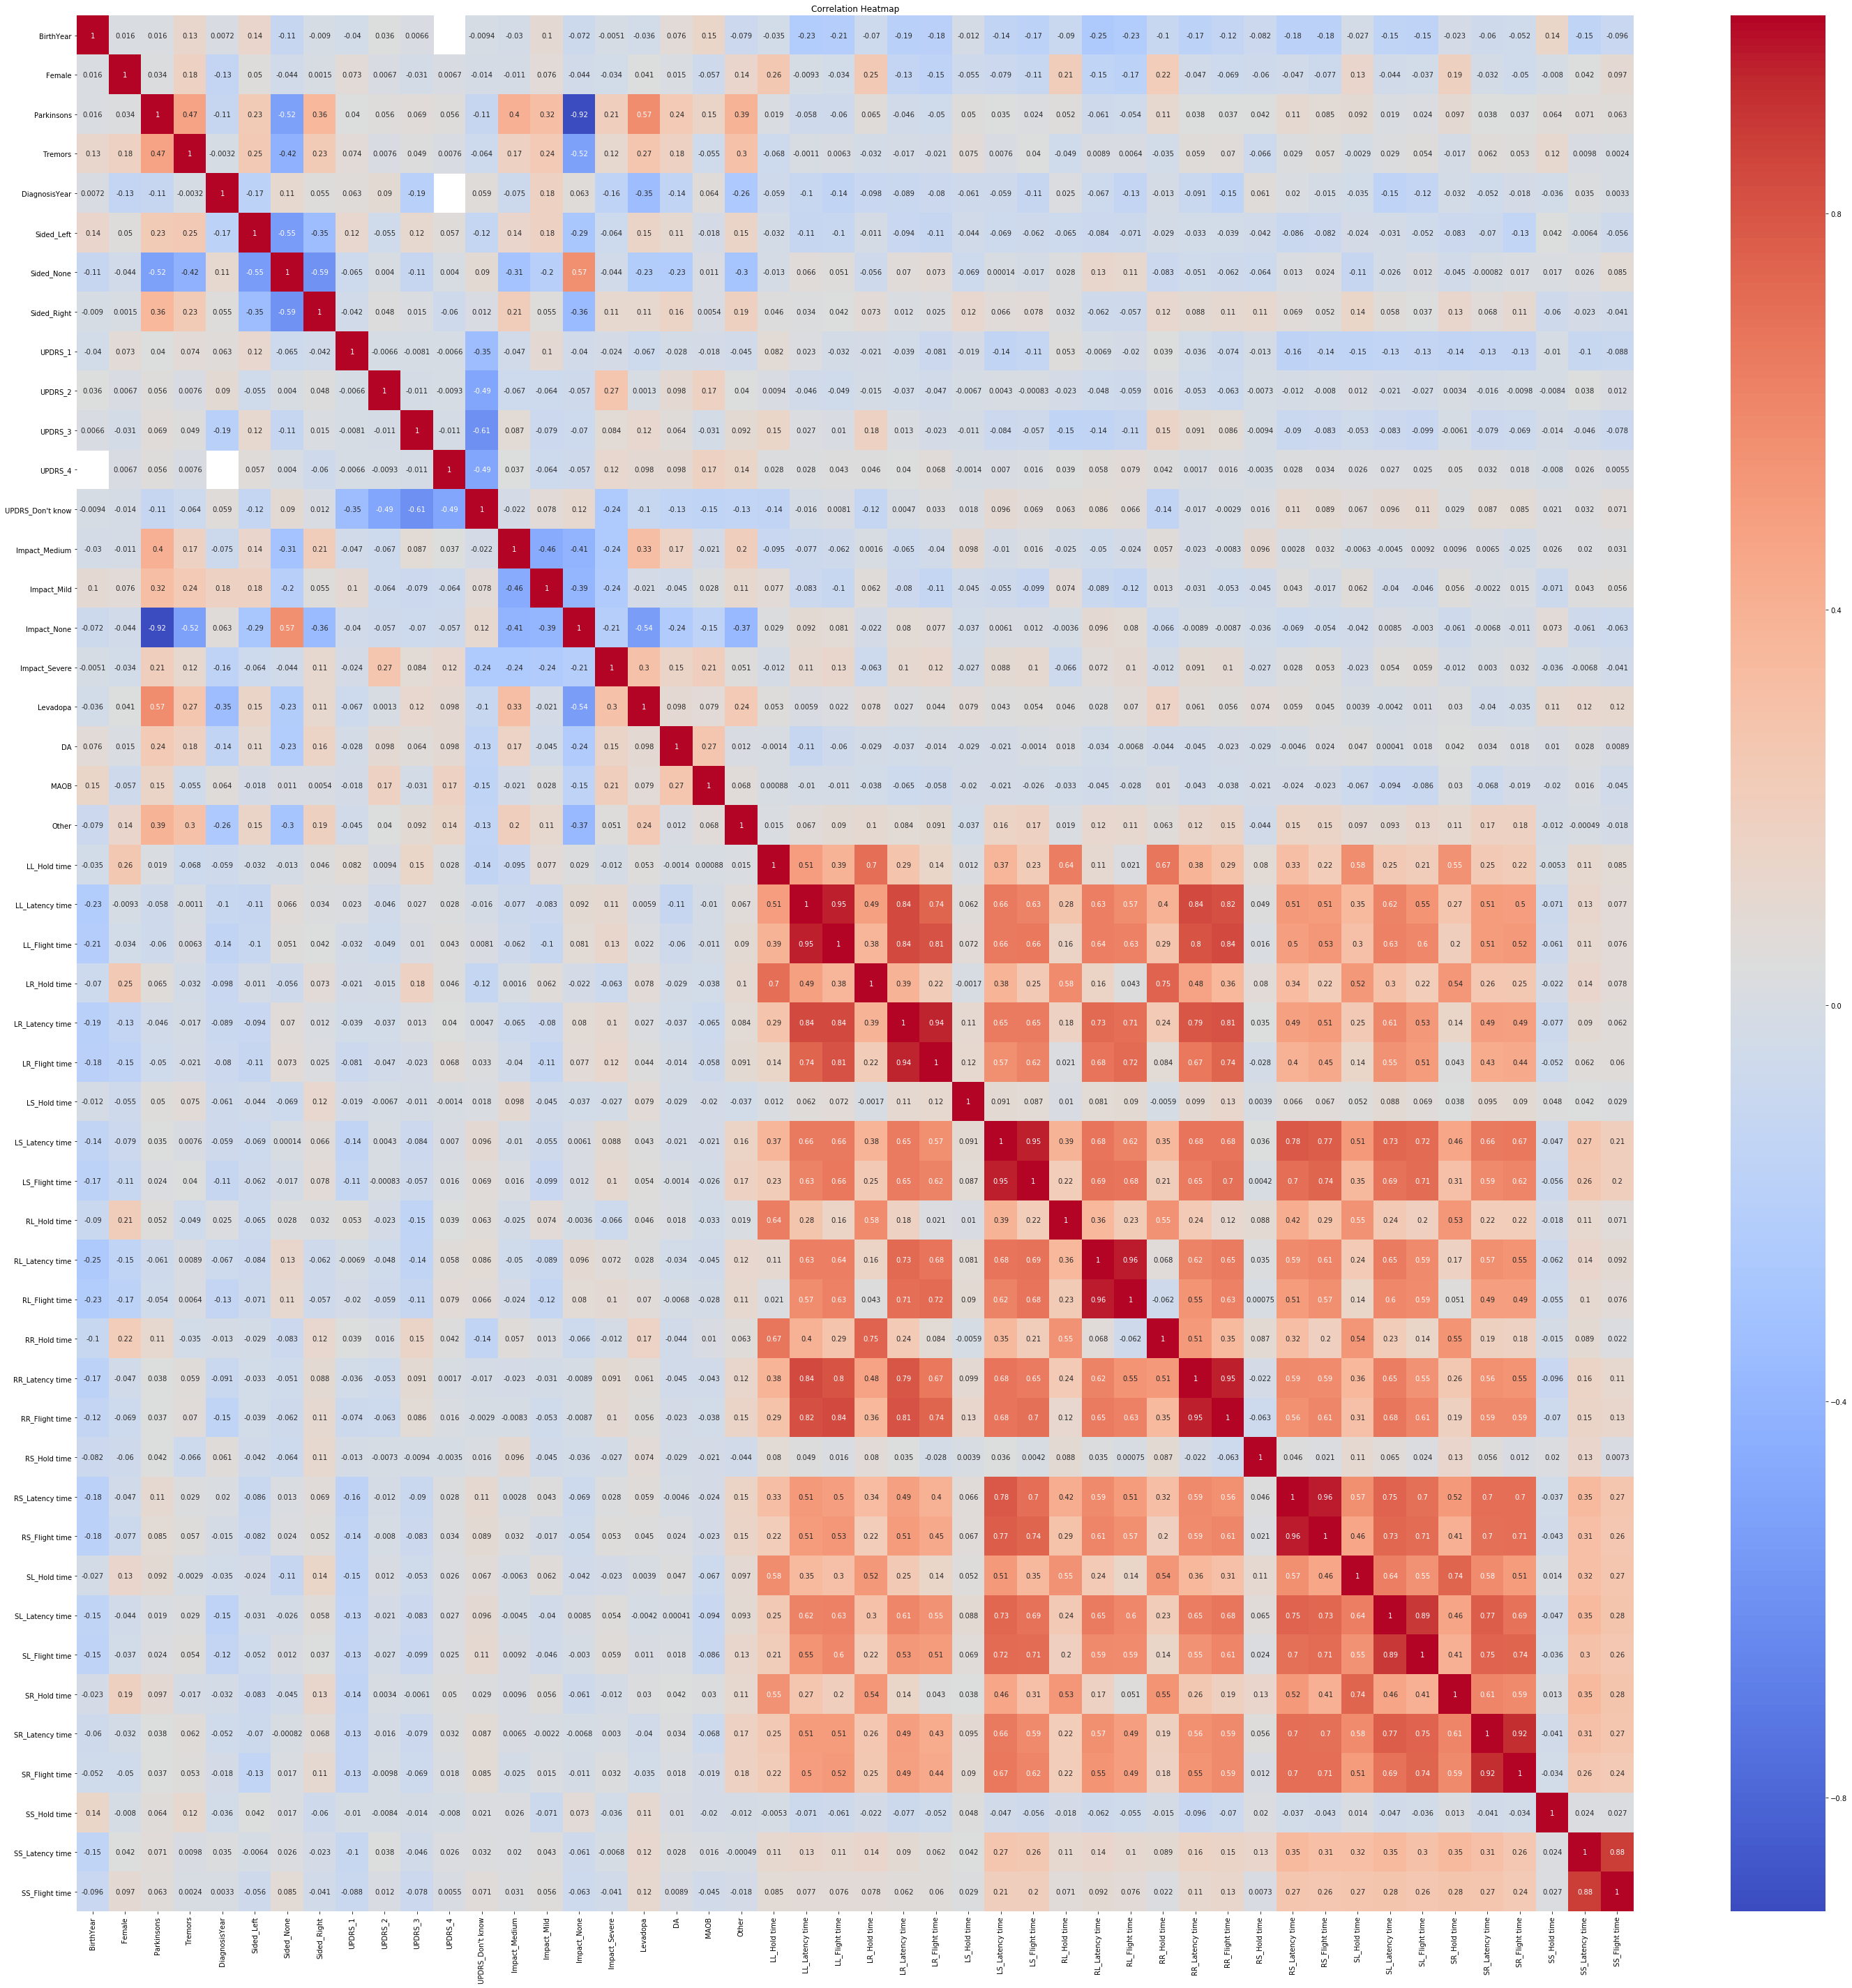

In [ ]:
numeric_df = combined_user_df.select_dtypes(include=['number'])
plt.figure(figsize=(50, 50))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Calculate correlation of all columns with 'Parkinsons'
parkinsons_correlation = numeric_df.corr()['Parkinsons'].sort_values(ascending=False)

# Display highest correlation scores related to 'Parkinsons'
print("Highest Correlation Scores related to Parkinsons:")
print(parkinsons_correlation)

Highest Correlation Scores related to Parkinsons:
Parkinsons          1.000000
Levadopa            0.574671
Tremors             0.474920
Impact_Medium       0.402082
Other               0.389418
Sided_Right         0.360205
Impact_Mild         0.320622
DA                  0.237875
Sided_Left          0.232605
Impact_Severe       0.205471
MAOB                0.153017
RR_Hold time        0.112387
RS_Latency time     0.105486
SR_Hold time        0.096578
SL_Hold time        0.091594
RS_Flight time      0.085169
SS_Latency time     0.070586
UPDRS_3             0.068989
LR_Hold time        0.064760
SS_Hold time        0.064223
SS_Flight time      0.063201
UPDRS_2             0.056198
UPDRS_4             0.056198
RL_Hold time        0.052306
LS_Hold time        0.049883
RS_Hold time        0.041554
UPDRS_1             0.039646
SR_Latency time     0.038302
RR_Latency time     0.037773
SR_Flight time      0.037479
RR_Flight time      0.036639
LS_Latency time     0.035025
Female              0.

## Cleaning final dataframe

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
combined_user_df.count()

BirthYear           180
Female              217
Parkinsons          217
Tremors             217
DiagnosisYear       147
Sided_Left          217
Sided_None          217
Sided_Right         217
UPDRS_1             217
UPDRS_2             217
UPDRS_3             217
UPDRS_4             217
UPDRS_Don't know    217
Impact_Medium       217
Impact_Mild         217
Impact_None         217
Impact_Severe       217
Levadopa            217
DA                  217
MAOB                217
Other               217
LL_Hold time        217
LL_Latency time     217
LL_Flight time      217
LR_Hold time        217
LR_Latency time     217
LR_Flight time      217
LS_Hold time        217
LS_Latency time     217
LS_Flight time      217
RL_Hold time        217
RL_Latency time     217
RL_Flight time      217
RR_Hold time        217
RR_Latency time     217
RR_Flight time      217
RS_Hold time        217
RS_Latency time     217
RS_Flight time      217
SL_Hold time        217
SL_Latency time     217
SL_Flight time  

In [ ]:
#Check data types
print(combined_user_df.dtypes)


BirthYear           float64
Female                int64
Parkinsons            int64
Tremors               int64
DiagnosisYear       float64
Sided_Left            uint8
Sided_None            uint8
Sided_Right           uint8
UPDRS_1               uint8
UPDRS_2               uint8
UPDRS_3               uint8
UPDRS_4               uint8
UPDRS_Don't know      uint8
Impact_Medium         uint8
Impact_Mild           uint8
Impact_None           uint8
Impact_Severe         uint8
Levadopa              int64
DA                    int64
MAOB                  int64
Other                 int64
LL_Hold time        float64
LL_Latency time     float64
LL_Flight time      float64
LR_Hold time        float64
LR_Latency time     float64
LR_Flight time      float64
LS_Hold time        float64
LS_Latency time     float64
LS_Flight time      float64
RL_Hold time        float64
RL_Latency time     float64
RL_Flight time      float64
RR_Hold time        float64
RR_Latency time     float64
RR_Flight time      

In [ ]:
#Inspect specific columns
print(combined_user_df['BirthYear'].describe())


count     180.000000
mean     1948.477778
std        10.331627
min      1927.000000
25%      1942.000000
50%      1948.000000
75%      1953.250000
max      1986.000000
Name: BirthYear, dtype: float64


In [ ]:
#Drop columns with NaN, infinity, or large values
combined_user_df.dropna(inplace=True)
combined_user_df = combined_user_df.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
#Check for NaN values
print(combined_user_df.isnull().sum())

BirthYear           0
Female              0
Parkinsons          0
Tremors             0
DiagnosisYear       0
Sided_Left          0
Sided_None          0
Sided_Right         0
UPDRS_1             0
UPDRS_2             0
UPDRS_3             0
UPDRS_4             0
UPDRS_Don't know    0
Impact_Medium       0
Impact_Mild         0
Impact_None         0
Impact_Severe       0
Levadopa            0
DA                  0
MAOB                0
Other               0
LL_Hold time        0
LL_Latency time     0
LL_Flight time      0
LR_Hold time        0
LR_Latency time     0
LR_Flight time      0
LS_Hold time        0
LS_Latency time     0
LS_Flight time      0
RL_Hold time        0
RL_Latency time     0
RL_Flight time      0
RR_Hold time        0
RR_Latency time     0
RR_Flight time      0
RS_Hold time        0
RS_Latency time     0
RS_Flight time      0
SL_Hold time        0
SL_Latency time     0
SL_Flight time      0
SR_Hold time        0
SR_Latency time     0
SR_Flight time      0
SS_Hold ti

In [ ]:
#Check for infinity values
print(np.isinf(combined_user_df).sum())


BirthYear           0
Female              0
Parkinsons          0
Tremors             0
DiagnosisYear       0
Sided_Left          0
Sided_None          0
Sided_Right         0
UPDRS_1             0
UPDRS_2             0
UPDRS_3             0
UPDRS_4             0
UPDRS_Don't know    0
Impact_Medium       0
Impact_Mild         0
Impact_None         0
Impact_Severe       0
Levadopa            0
DA                  0
MAOB                0
Other               0
LL_Hold time        0
LL_Latency time     0
LL_Flight time      0
LR_Hold time        0
LR_Latency time     0
LR_Flight time      0
LS_Hold time        0
LS_Latency time     0
LS_Flight time      0
RL_Hold time        0
RL_Latency time     0
RL_Flight time      0
RR_Hold time        0
RR_Latency time     0
RR_Flight time      0
RS_Hold time        0
RS_Latency time     0
RS_Flight time      0
SL_Hold time        0
SL_Latency time     0
SL_Flight time      0
SR_Hold time        0
SR_Latency time     0
SR_Flight time      0
SS_Hold ti

In [ ]:
print("Highest absolute Correlation Scores related to Parkinsons:")
for feature, correlation_score in parkinsons_correlation.items():
    if abs(correlation_score) > 0.2:
        print(f"{feature}: {correlation_score}")

Highest absolute Correlation Scores related to Parkinsons:
Parkinsons: 1.0
Levadopa: 0.5746711351549231
Tremors: 0.47491993667633176
Impact_Medium: 0.4020815913643023
Other: 0.38941762997452767
Sided_Right: 0.36020491664729093
Impact_Mild: 0.32062227661946274
DA: 0.2378746773826881
Sided_Left: 0.23260504599499615
Impact_Severe: 0.205471127381187
Sided_None: -0.522535066638959
Impact_None: -0.9153345346380631


## Now let's decide our metrics

##### This model is developed for medical diagnosis to detect the probability of a patient having Parkinson's disease based on the provided input data. Given the medical nature of the task, it's crucial to consider evaluation metrics that capture different aspects of model performance, particularly focusing on the positive class (Parkinson's detected) due to its higher importance. Additionally, false negatives are particularly costly in diseases with limited treatment options like Parkinson's.

##### The Evaluation Metrics are as follows:
1. **Brier Score**:
   - The Brier score is a proper scoring rule that measures the accuracy of probabilistic predictions. It quantifies the average squared difference between predicted probabilities and actual outcomes. Lower Brier scores indicate better calibration and accuracy of probability estimates.

2. **Precision-Recall Area Under the Curve (PR AUC)**:
   - PR AUC measures the area under the precision-recall curve, which plots the precision (positive predictive value) against recall (true positive rate) at different threshold values. PR AUC is suitable for imbalanced datasets and prioritizes the performance of the positive class. Higher PR AUC values indicate better precision-recall trade-offs.

3. **F2 Score** (optional):
   - The F2 score is an extension of the F1 score that assigns more weight to recall. It is particularly useful when false negatives are more costly than false positives. In the context of Parkinson's disease diagnosis, where false negatives can have significant consequences, the F2 score provides a balanced evaluation metric that prioritizes recall while considering precision.

These evaluation metrics collectively provide insights into different aspects of model performance, including calibration, discrimination, and the trade-off between precision and recall. By considering these metrics, we can assess the model's effectiveness in accurately predicting Parkinson's disease probability while minimizing false negatives, which is crucial for patient care in medical diagnosis scenarios.


## Building a neural network for classification

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [ ]:
X = combined_user_df.drop('Parkinsons', axis=1)  #Dropping the target column from features
y = combined_user_df['Parkinsons']  #Assigning the target variable

#Verify the shape of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (130, 47)
Shape of y: (130,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#Apply SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

#### Function: `create_model`

##### Description:
This function creates a neural network model for binary classification tasks. The model architecture consists of three fully connected layers: an input layer with the specified number of neurons, a hidden layer with the same number of neurons and specified activation function, and an output layer with a single neuron and sigmoid activation function for binary classification. The model is compiled with the specified optimizer, loss function, and accuracy metric.

##### Parameters:
- `neurons` (int): The number of neurons in the hidden layers.
- `activation` (str): The activation function to be used in the hidden layers.
- `optimizer` (str or optimizer object): The optimizer to be used during training.
- `loss` (str or loss function): The loss function to be optimized during training.

##### Returns:
- `model` (tensorflow.keras.models.Sequential): The compiled neural network model for binary classification.


In [ ]:
def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(47,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='softmax')) #change output to 1 neuron and sigmoid activation for binary classification

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

#### Hyperparameter tuning

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [ ]:
param_grid = {
    "neurons": [16, 32],  #Try different numbers of neurons in the hidden layers
    "batch_size": [10, 20],  #Try different batch sizes
    "epochs": [10, 15],  #try different numbers of epochs
    "activation": ['sigmoid', 'tanh'],  #Different activation functions
    "optimizer": ['adam', 'rmsprop'],  #Different optimizers
    "loss": ['binary_crossentropy', 'squared_hinge', 'kullback_leibler_divergence']
}

### Parameters in the Grid:

1. **`neurons`**: This parameter represents the number of neurons in the hidden layers of the neural network. By varying this parameter, you can control the complexity and capacity of the model.

2. **`batch_size`**: Batch size refers to the number of samples processed before the model's weights are updated during training. Different batch sizes can affect the convergence speed and memory usage during training.

3. **`epochs`**: An epoch is one complete pass through the entire training dataset. This parameter determines the number of times the learning algorithm will work through the entire training dataset. More epochs can potentially lead to better convergence but might also increase the risk of overfitting.

4. **`activation`**: Activation functions introduce non-linearity to the neural network, allowing it to learn complex patterns in the data. Options provided here include 'sigmoid' and 'tanh', which are common choices for binary classification tasks.

5. **`optimizer`**: Optimizers are algorithms used to update the weights of the neural network based on the loss function. Options include 'adam' and 'rmsprop', which are popular optimizers known for their efficiency and effectiveness in various scenarios.

6. **`loss`**: Loss functions measure the error between predicted values and actual values during training. Options include 'binary_crossentropy', 'squared_hinge', and 'kullback_leibler_divergence', each suitable for different types of tasks and output distributions.

### Choice of Optimizers, Activations, and Losses:

1. **Optimizers**:
   - **Adam**: Adam combines the advantages of two other extensions of stochastic gradient descent, namely Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). It adapts learning rates for each parameter, providing faster convergence and handling sparse gradients efficiently.
   - **RMSProp**: RMSProp is another popular optimization algorithm that maintains per-parameter learning rates by dividing the learning rate for a weight by a running average of the magnitudes of recent gradients for that weight. It is well-suited for recurrent neural networks.

2. **Activation Functions**:
   - **Sigmoid**: Sigmoid activation function squashes the input values between 0 and 1, which is suitable for binary classification tasks where the output needs to be interpreted as probabilities.
   - **Tanh**: Tanh activation function squashes the input values between -1 and 1, offering stronger gradients compared to the sigmoid function, which can aid in training deeper networks.

3. **Loss Functions**:
   - **Binary Crossentropy**: This is a common loss function for binary classification tasks. It measures the difference between the true labels and the predicted probabilities for binary outcomes.
   - **Squared Hinge**: This loss function is suitable for binary classification tasks and penalizes predictions that are not on the correct side of the decision boundary.
   - **Kullback-Leibler Divergence**: This is a measure of how one probability distribution diverges from a second, expected probability distribution. It is often used in scenarios where there is a need to measure the difference between two probability distributions.

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

best_params = grid_result.best_params_
best_params

{'activation': 'sigmoid',
 'batch_size': 10,
 'epochs': 10,
 'loss': 'binary_crossentropy',
 'neurons': 16,
 'optimizer': 'adam'}

#### Final model

In [ ]:
model = Sequential()
model.add(Dense(16, activation=best_params['activation'], input_shape=(47,)))
model.add(Dense(16, activation=best_params['activation']))
model.add(Dense(1, activation='sigmoid'))  #change output to 1 neuron and sigmoid activation for binary classification
model.compile(best_params['optimizer'], loss=best_params['loss'], metrics=['accuracy'])

### Model evaluation

In [ ]:
from sklearn.metrics import brier_score_loss, precision_recall_curve, auc, fbeta_score

In [ ]:
#Predict probabilities
y_pred_proba = model.predict(X_test)

#Flatten predictions if needed (e.g., for binary classification)
y_pred_proba = y_pred_proba.flatten()

#Compute Brier score
brier = brier_score_loss(y_test, y_pred_proba)

#Compute precision-recall curve and PR AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

#Compute F2 score
f2 = fbeta_score(y_test, y_pred_proba > 0.5, beta=2)

print("Brier Score:", brier)
print("PR AUC:", pr_auc)
print("F2 Score:", f2)

Brier Score: 0.17775930794859052
PR AUC: 0.8653663499396829
F2 Score: 0.9893048128342247


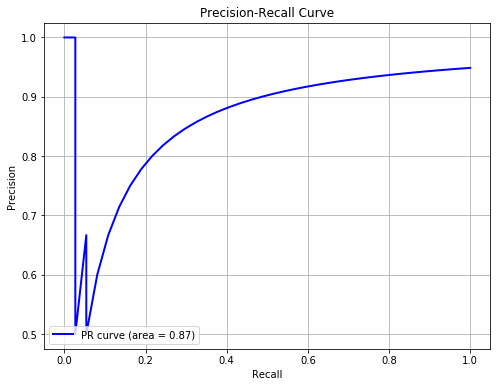

In [ ]:
# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()